In [2]:
import pytrec_eval 
import json
import re
import numpy as np
import sys
import codecs
import struct

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from elasticsearch import Elasticsearch, ElasticsearchException, SerializationError,TransportError

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from pprint import pprint
es = Elasticsearch("localhost:9211", log="trace", timeout=1000)
print(es)

<Elasticsearch([{'host': 'localhost', 'port': 9211}])>


In [3]:
class PRCurve:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, label,  precarr, linestyle=None, color=None):
        self.plt=plt
        self.label=label
        self.precarr=list(precarr)
        self.linestyle=linestyle
        self.color=color
        self.ydata=[]
        self.l2d=None
    
    def mp_plot(self, linestyle=None, color=None):
        if linestyle==None and color==None:
            self.l2d =plt.plot(self.REC_ARR, self.precarr, label=self.label)[0]
        else:
            self.l2d =plt.plot(x=self.REC_ARR, y=self.precarr, label=self.label, linestyle=linestyle, color=color)[0]
        return self.l2d

class CurveWithLabel:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, averages, name):
        self.plt=plt
        self.name=name
        self.averages=averages
        self.summary_measures=self.extract()
        self.label=self.make_label()
        self.l2d=self.mp_plot()
        
    def extract(self):
        summary_measures=dict()
        print("self.averages:",self.averages)
        for ky in list(self.averages.keys()):
            if 'iprec' not in ky:
                summary_measures.update({ky : self.averages[ky]})
                _=self.averages.pop(ky)
                
        return summary_measures
    
    def make_label(self):
        ret=self.name+":"
        for ky in self.summary_measures:
            val=self.summary_measures[ky]
            ret += " " + ky + "=" + str(val)[0:5] +","
        ret=ret.strip(',')    
        return ret
    
    def mp_plot(self, linestyle=None, color=None):
        p=PRCurve(self.label, self.averages.values(), linestyle=linestyle, color=color)
        p.mp_plot(linestyle=linestyle, color=color)
        return p.l2d

In [4]:
index_name = "publication"
doc_type = "html"
remove_stopwords = True
stem = False
queryfile="query.txt"

INDEX_SETTINGS = {  # two shards with a single replica
    "settings" : {
        "index" : {
            "number_of_shards" : 6,
            "number_of_replicas" : 1
           #,"similarity" : { "default" : { "type" : "LMJelinekMercer", "lambda":"0.4" }
            }
        }
        ,
    "mappings": {
            "html": {
            "properties": {
#                "post_date": { "type": "date" }
#                ,
                "title": {"type": "text" }
                ,
#                "id": { "type": "keyword"}
#                ,
                "text": { "type": "text" }
                ,
                "description": {"type": "text"}
                ,
                "keywords": {"type": "keyword"}
                ,
                "classification":{"type": "text"}
                }
            }
        }
    }

DCTR=0
DOCS_IN_FILE=0
es = Elasticsearch("localhost:9211", timeout=100)
if es.indices.exists(index_name):
    print("index exists")
    #es.indices.delete(index=INDEX_NAME)
else:
    print("cannot")
    sys.exit()
#pprint (es.indices.stats(index="publication"))

body = {
	
    "size": 20,           # get 100 docs (default = 10)
    "_source": ["work", "work.subjects"], # get only wanted fields
	 "query": { 
         "query_string":{"query":"charlotte brontë"}# the query
	 }
}
result=es.search(index="publication", body=body)

type(result)
#pprint(result)

index exists


dict

In [5]:
def run(es=es, 
        index="publication", 
        queryfile="query.txt",
        similarity="DFR", 
        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
        parameterValues=["g",          "l",            "h2", "4.0"]
       ):
    es.indices.close(index=index)
    val_dict={"type":similarity}
    for i in range(len(parameterNames)):
        val_dict[parameterNames[i]]=parameterValues[i]
        
    print("val_dict=", val_dict)
    def_dict={"default":val_dict}
    sim_dict= {"similarity": def_dict}
    setting_dict={"index":sim_dict}
    similarity_setting=json.JSONEncoder().encode(setting_dict)
    print("setting", similarity_setting)
    es.indices.put_settings(index=index, body=similarity_setting)
    es.indices.open(index=index)
    es.indices.refresh(index=index)
    
    qrels=dict()
    with open("qrels.query.adhoc", 'r') as myfile: 
            qrel_lines=myfile.readlines()

    for line in qrel_lines:
        qnr, zero, docnr, rel=line.split()
        if qnr not in qrels.keys():
            qrels[qnr]=dict()
        qrels[qnr][docnr]=int(rel)

    queries=dict()
    with open(queryfile) as qfile:
        qlines=qfile.readlines()

    for line in qlines:
        qnr, qstring=line.split(':')
        qstring=qstring.strip('\n')
        if qnr not in queries.keys():
            queries[qnr]=qstring

    run=dict()    
    for qr in queries.keys():
        query=queries[qr]
        res = es.search(index=index_name, q=query, _source=False, size=1000)
        for hit in res['hits']['hits']:
            if qr not in run.keys():
                run[qr]=dict()
            run[qr][hit['_id']]=hit['_score']    

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, { 'iprec_at_recall', 'map', 'ndcg', 'Rprec'})
    eval=evaluator.evaluate(run)


    avres=dict()

    for q in eval.keys():
        for res in eval[q].keys():
            if res not in avres.keys():
                avres[res]=0 #initialize
            avres[res]+=eval[q][res]/len(eval)#update average
        
    return avres

def plotCombined(cwls):
    colors=['red', 'aqua', 'darkmagenta', 'sienna', 'brown', 'grey']
    linestyles=['-', '--', '-.', '.', ':', '-' ]
    l2ds=list()
    ax=None
    for c in range(len(cwls)):
        cwl=cwls[c]
        ls=linestyles[c]
        color=colors[c]
       
        l2ds.append(cwl.mp_plot())
    
    #ax.legend(l2ds, labels)
    plt.legend()
    plt.show()
    #plt.gcf().clear()

curvesWithLabels=list()

val_dict= {'type': 'DFR', 'basic_model': 'g', 'after_effect': 'l', 'normalization': 'h2', 'normalization.h2.c': '4.0'}
setting {"index": {"similarity": {"default": {"type": "DFR", "basic_model": "g", "after_effect": "l", "normalization": "h2", "normalization.h2.c": "4.0"}}}}
self.averages: {}


ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

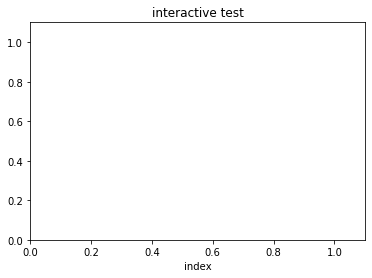

In [6]:
curvesWithLabels=list()

plt.ion() #Turn on interactive mode
plt.axis([0.0, 1.1, 0.0, 1.1])
plt.title("interactive test")
plt.xlabel("index")

avres=run(es, similarity= "DFR",
          parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"],
          parameterValues=["g",          "l",            "h2", "4.0"])

tfidf=CurveWithLabel(avres, "tfidf")

curvesWithLabels.append(tfidf)
plotCombined(curvesWithLabels)